In [1]:
%cd ..

/home/zengyun1/gnn/2/TMP_NN


/home/zengyun1/App/miniconda3/envs/gnn/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import torch
import pickle
with open('Dataset/Bergman_cyclization.pkl', 'rb') as file:
    data_list = pickle.load(file)

In [4]:
from torch.utils.data import TensorDataset, DataLoader,random_split

def get_datalist(data_list,atom_list):
    data_size = len(data_list)
    atom_num = len(atom_list)
    x3d_total = torch.empty(data_size, atom_num, 8, 8, 8)  
    x2d_total = torch.empty(data_size, atom_num, 10, 20)
    x1d_total = torch.empty(data_size, atom_num, 23)
    x0d_total = torch.empty(data_size, 13)  # 
    y_total = torch.empty(data_size, 1)  
    for idx, G in enumerate(data_list):
        x3d_total[idx] = G.x3d[atom_list, :, :, :]
        x2d_total[idx] = G.x2d[atom_list, :, :]
        x1d_total[idx] = G.x[atom_list, :23]
        x0d_total[idx] = G.global_features

        # x0d_total[idx] = torch.cat((G.global_features[:1], G.global_features[3:]))
        y_total[idx] = G.y

    dataset = TensorDataset(x3d_total, x2d_total, x1d_total, x0d_total, y_total)
    return dataset

In [5]:
def train_and_test(atom_list,data_list):
    
    atom_num = len(atom_list)
    dataset = get_datalist(data_list,atom_list)
    
    train_size = int(0.80 * len(dataset))
    test_size = len(dataset) - train_size
    
    # torch.manual_seed(2025)
    # Randomly partition the data set
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    
    
    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

    criterion = nn.MSELoss()
    criterion2 = nn.L1Loss()
    model=MultimodalMoleculeNet().to(device)
    
    total_actuals = []
    total_predictions = []
    train_loss_list = []
    val_loss_list = []
    LR = 0.01
    
    optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)  # 定义优化器
    scheduler = StepLR(optimizer, step_size=10, gamma=0.9)  # 定义学习率调度器
    num_epochs = 1000
    
    lr_list = []  # 列表来存储每个epoch的学习率
    pbar = tqdm(range(num_epochs))
    
    for epoch in pbar:
        model.train()  # 设置模型为训练模式
        running_loss = 0.0
        for x3d, x2d, x1d, x0d, targets  in train_dataloader:  # 假设我们只用x3d和targets进行训练
            x3d, x2d, x1d, targets = x3d.to(device), x2d.to(device), x1d.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(x3d,x2d,x1d)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_loss = running_loss / (2 * len(train_dataloader)) 
    
        scheduler.step()
        current_lr = optimizer.state_dict()['param_groups'][0]['lr']
        lr_list.append(current_lr)
    
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for x3d, x2d, x1d, x0d, targets  in test_dataloader:
                x3d, x2d, x1d, targets = x3d.to(device), x2d.to(device), x1d.to(device), targets.to(device)
                outputs = model(x3d,x2d,x1d)
                loss = criterion(outputs, targets)
                total_val_loss += loss.item()
    
        avg_val_loss = total_val_loss / len(test_dataloader)
        pbar.set_postfix(dict(Training=f"{avg_loss:.1f}", Validation=f"{avg_val_loss:.1f}"))
    
        model.eval() 
        actuals = []
        predictions = []
        
        with torch.no_grad():
            for x3d,x2d,x1d,x0d, targets  in train_dataloader:
                x3d,x2d,x1d,x0d, targets = x3d.to(device),x2d.to(device),x1d.to(device),x0d.to(device),targets.to(device)
        
        
                outputs = model(x3d,x2d,x1d)
                actuals.extend(targets.cpu().numpy())
                predictions.extend(outputs.cpu().numpy())
        
        actuals = np.array(actuals)
        predictions = np.array(predictions)
        total_actuals.append(actuals)
        total_predictions.append(predictions)
        train_loss_list.append(avg_loss)
        val_loss_list.append(avg_val_loss)

    return [model,train_loss_list,val_loss_list,total_actuals,total_predictions]

In [6]:
from script.model import MultimodalMoleculeNet
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=MultimodalMoleculeNet().to(device)
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

In [7]:
atom_list = [
[0,5],
[2,3],
[0,2,3,5],
[0,1,4,5],
[0,1,2,3,4,5],
[6,0,1,2,3,4,5,9],
[0,1,2,7,8,3,4,5],
[6,0,1,2,7,8,3,4,5,9],
[0,1,2,3,4,5,6,7,8,9],
[5,3,2,1,0,4],
[5,2,2,1,3,4],
[0,1,2],
[5,4,3],
]

In [8]:
model_performance=[]
for i in range(len(atom_list)):
    tmp = train_and_test(atom_list[i],data_list)
    print(atom_list[i],min(tmp[2]))
    model_performance.append(tmp)

 34%|███▍      | 345/1000 [05:33<10:32,  1.04it/s, Training=2.7, Validation=6.9] 


KeyboardInterrupt: 

In [10]:
atom_list=[
    [0],
    [0, 1],
    [0, 1, 2],
    [0, 1, 2, 3],
    [0, 1, 2, 3, 4],
    [0, 1, 2, 3, 4, 5],
    [0, 1, 2, 3, 4, 5, 6],
    [0, 1, 2, 3, 4, 5, 6, 7],
    [0, 1, 2, 3, 4, 5, 6, 7, 8],
    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    [0, 1, 3, 6, 7],
    [5, 2, 4, 9, 8],
    [0,5],
    [1,2],
    [3,4],
    [6,9],
    [7,8],
    [0,1,3],
    [5,2,5],
    [6,9,7,8]
]

In [11]:
for abc in range(10):
    model_performance=[]
    for i in range(len(atom_list)):
        tmp = train_and_test(atom_list[i],data_list)
        print(atom_list[i],min(tmp[2]))
        model_performance.append(tmp)
    print("===========================")

100%|██████████| 1000/1000 [15:41<00:00,  1.06it/s, Training=2.4, Validation=11.4]


[0] 9.32816209111895


100%|██████████| 1000/1000 [16:15<00:00,  1.03it/s, Training=2.2, Validation=7.4]


[0, 1] 7.0551460811070035


100%|██████████| 1000/1000 [16:09<00:00,  1.03it/s, Training=1.8, Validation=9.4]


[0, 1, 2] 8.650061658450536


100%|██████████| 1000/1000 [16:01<00:00,  1.04it/s, Training=2.3, Validation=8.2]


[0, 1, 2, 3] 7.3851209197725565


100%|██████████| 1000/1000 [16:01<00:00,  1.04it/s, Training=2.5, Validation=7.0]


[0, 1, 2, 3, 4] 6.590821186701457


100%|██████████| 1000/1000 [16:09<00:00,  1.03it/s, Training=2.3, Validation=5.4]


[0, 1, 2, 3, 4, 5] 4.8817691178548905


100%|██████████| 1000/1000 [16:04<00:00,  1.04it/s, Training=2.2, Validation=7.6]


[0, 1, 2, 3, 4, 5, 6] 7.166624449548268


100%|██████████| 1000/1000 [16:13<00:00,  1.03it/s, Training=2.5, Validation=6.5]


[0, 1, 2, 3, 4, 5, 6, 7] 6.292160448573885


100%|██████████| 1000/1000 [16:19<00:00,  1.02it/s, Training=2.6, Validation=10.5]


[0, 1, 2, 3, 4, 5, 6, 7, 8] 9.201211214065552


100%|██████████| 1000/1000 [16:19<00:00,  1.02it/s, Training=2.6, Validation=5.7]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 4.8883350519906905


100%|██████████| 1000/1000 [16:10<00:00,  1.03it/s, Training=2.2, Validation=10.5]


[0, 1, 3, 6, 7] 9.48601752235776


100%|██████████| 1000/1000 [16:08<00:00,  1.03it/s, Training=2.7, Validation=9.9]


[5, 2, 4, 9, 8] 9.087053162711006


100%|██████████| 1000/1000 [15:54<00:00,  1.05it/s, Training=2.0, Validation=7.1]


[0, 5] 6.5591392914454145


100%|██████████| 1000/1000 [15:53<00:00,  1.05it/s, Training=2.2, Validation=13.8]


[1, 2] 12.887070723942347


100%|██████████| 1000/1000 [16:00<00:00,  1.04it/s, Training=2.4, Validation=15.6]


[3, 4] 12.830069723583403


100%|██████████| 1000/1000 [15:55<00:00,  1.05it/s, Training=1.9, Validation=7.0]


[6, 9] 6.27067708401453


100%|██████████| 1000/1000 [16:01<00:00,  1.04it/s, Training=2.6, Validation=17.1]


[7, 8] 14.735850345520745


100%|██████████| 1000/1000 [16:05<00:00,  1.04it/s, Training=2.2, Validation=9.7]


[0, 1, 3] 8.892603885559808


100%|██████████| 1000/1000 [16:02<00:00,  1.04it/s, Training=2.2, Validation=9.4]


[5, 2, 5] 8.103772623198372


100%|██████████| 1000/1000 [16:14<00:00,  1.03it/s, Training=2.4, Validation=7.1]


[6, 9, 7, 8] 6.053180095695314


100%|██████████| 1000/1000 [15:28<00:00,  1.08it/s, Training=2.7, Validation=12.7]


[0] 11.385001613980247


100%|██████████| 1000/1000 [16:02<00:00,  1.04it/s, Training=2.2, Validation=11.0]


[0, 1] 9.961283638363792


100%|██████████| 1000/1000 [16:04<00:00,  1.04it/s, Training=2.0, Validation=10.5]


[0, 1, 2] 9.012985672269549


100%|██████████| 1000/1000 [16:14<00:00,  1.03it/s, Training=2.0, Validation=10.8]


[0, 1, 2, 3] 9.893331243878318


100%|██████████| 1000/1000 [16:13<00:00,  1.03it/s, Training=2.1, Validation=8.4]


[0, 1, 2, 3, 4] 7.593416514850798


100%|██████████| 1000/1000 [16:12<00:00,  1.03it/s, Training=2.1, Validation=6.4]


[0, 1, 2, 3, 4, 5] 5.999650966553461


100%|██████████| 1000/1000 [16:14<00:00,  1.03it/s, Training=2.1, Validation=5.8]


[0, 1, 2, 3, 4, 5, 6] 5.2869475200062706


100%|██████████| 1000/1000 [16:15<00:00,  1.03it/s, Training=2.1, Validation=9.7]


[0, 1, 2, 3, 4, 5, 6, 7] 8.453786140396481


100%|██████████| 1000/1000 [16:24<00:00,  1.02it/s, Training=2.2, Validation=7.7] 


[0, 1, 2, 3, 4, 5, 6, 7, 8] 7.556677500406901


100%|██████████| 1000/1000 [16:28<00:00,  1.01it/s, Training=2.3, Validation=6.5]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 5.820788797878084


100%|██████████| 1000/1000 [16:16<00:00,  1.02it/s, Training=2.3, Validation=15.8]


[0, 1, 3, 6, 7] 10.500223977225167


100%|██████████| 1000/1000 [16:08<00:00,  1.03it/s, Training=2.7, Validation=9.0]


[5, 2, 4, 9, 8] 8.271538757142567


100%|██████████| 1000/1000 [15:58<00:00,  1.04it/s, Training=2.2, Validation=8.3]


[0, 5] 7.328855196634929


100%|██████████| 1000/1000 [15:58<00:00,  1.04it/s, Training=2.0, Validation=12.2]


[1, 2] 10.101885398228964


100%|██████████| 1000/1000 [16:00<00:00,  1.04it/s, Training=2.0, Validation=11.9]


[3, 4] 11.26112717673892


100%|██████████| 1000/1000 [16:37<00:00,  1.00it/s, Training=2.4, Validation=6.0]


[6, 9] 5.181860361780439


100%|██████████| 1000/1000 [16:16<00:00,  1.02it/s, Training=2.1, Validation=18.0]


[7, 8] 13.629027128219604


100%|██████████| 1000/1000 [16:23<00:00,  1.02it/s, Training=2.2, Validation=8.6] 


[0, 1, 3] 7.9612424827757335


100%|██████████| 1000/1000 [16:08<00:00,  1.03it/s, Training=2.5, Validation=11.9]


[5, 2, 5] 10.01525252205985


100%|██████████| 1000/1000 [16:09<00:00,  1.03it/s, Training=2.0, Validation=7.1]


[6, 9, 7, 8] 6.4738733144033525


100%|██████████| 1000/1000 [15:20<00:00,  1.09it/s, Training=2.3, Validation=9.1]


[0] 8.884809028534661


100%|██████████| 1000/1000 [16:01<00:00,  1.04it/s, Training=2.5, Validation=11.7]


[0, 1] 11.054179214295887


100%|██████████| 1000/1000 [16:10<00:00,  1.03it/s, Training=2.7, Validation=9.6]


[0, 1, 2] 9.304993741569065


100%|██████████| 1000/1000 [16:04<00:00,  1.04it/s, Training=2.7, Validation=11.9]


[0, 1, 2, 3] 11.258280720029559


100%|██████████| 1000/1000 [16:09<00:00,  1.03it/s, Training=2.3, Validation=6.9]


[0, 1, 2, 3, 4] 5.745162492706662


100%|██████████| 1000/1000 [16:10<00:00,  1.03it/s, Training=2.5, Validation=5.7]


[0, 1, 2, 3, 4, 5] 5.175265806061881


100%|██████████| 1000/1000 [16:08<00:00,  1.03it/s, Training=2.4, Validation=9.0]


[0, 1, 2, 3, 4, 5, 6] 8.022646279562087


100%|██████████| 1000/1000 [16:21<00:00,  1.02it/s, Training=2.2, Validation=7.6]


[0, 1, 2, 3, 4, 5, 6, 7] 6.980706422101884


100%|██████████| 1000/1000 [16:18<00:00,  1.02it/s, Training=2.1, Validation=6.3]


[0, 1, 2, 3, 4, 5, 6, 7, 8] 5.803489650998797


100%|██████████| 1000/1000 [16:27<00:00,  1.01it/s, Training=2.1, Validation=6.8]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 5.519829545702253


100%|██████████| 1000/1000 [16:48<00:00,  1.01s/it, Training=2.3, Validation=12.4]


[0, 1, 3, 6, 7] 11.714756999697004


100%|██████████| 1000/1000 [17:01<00:00,  1.02s/it, Training=2.3, Validation=10.0]


[5, 2, 4, 9, 8] 7.931990498588199


100%|██████████| 1000/1000 [16:41<00:00,  1.00s/it, Training=2.5, Validation=6.4]


[0, 5] 6.097311774889628


100%|██████████| 1000/1000 [16:41<00:00,  1.00s/it, Training=2.2, Validation=12.9]


[1, 2] 12.654241595949445


100%|██████████| 1000/1000 [16:27<00:00,  1.01it/s, Training=2.1, Validation=11.7]


[3, 4] 11.494386650267101


100%|██████████| 1000/1000 [16:30<00:00,  1.01it/s, Training=2.0, Validation=7.2]


[6, 9] 6.015945383480617


100%|██████████| 1000/1000 [16:45<00:00,  1.01s/it, Training=2.6, Validation=15.8]


[7, 8] 13.562609604426793


100%|██████████| 1000/1000 [16:51<00:00,  1.01s/it, Training=2.4, Validation=10.0]


[0, 1, 3] 8.152508349645705


100%|██████████| 1000/1000 [16:30<00:00,  1.01it/s, Training=2.5, Validation=11.2]


[5, 2, 5] 9.409178949537731


100%|██████████| 1000/1000 [16:54<00:00,  1.01s/it, Training=2.2, Validation=5.3]


[6, 9, 7, 8] 5.091547721908206


100%|██████████| 1000/1000 [15:51<00:00,  1.05it/s, Training=2.5, Validation=12.9]


[0] 10.413173584710984


100%|██████████| 1000/1000 [18:38<00:00,  1.12s/it, Training=2.2, Validation=10.1]


[0, 1] 9.740267492475963


100%|██████████| 1000/1000 [16:11<00:00,  1.03it/s, Training=2.5, Validation=10.9]


[0, 1, 2] 9.809866212663197


100%|██████████| 1000/1000 [16:32<00:00,  1.01it/s, Training=2.3, Validation=9.7]


[0, 1, 2, 3] 8.937404138701302


100%|██████████| 1000/1000 [16:20<00:00,  1.02it/s, Training=2.5, Validation=6.6]


[0, 1, 2, 3, 4] 5.679762181781587


100%|██████████| 1000/1000 [17:29<00:00,  1.05s/it, Training=2.4, Validation=6.4]


[0, 1, 2, 3, 4, 5] 4.683373428526378


100%|██████████| 1000/1000 [16:50<00:00,  1.01s/it, Training=2.4, Validation=7.7]


[0, 1, 2, 3, 4, 5, 6] 6.928138063067482


100%|██████████| 1000/1000 [16:49<00:00,  1.01s/it, Training=2.4, Validation=6.1]


[0, 1, 2, 3, 4, 5, 6, 7] 5.643917742229643


100%|██████████| 1000/1000 [17:01<00:00,  1.02s/it, Training=2.6, Validation=8.2]


[0, 1, 2, 3, 4, 5, 6, 7, 8] 7.417979785374233


100%|██████████| 1000/1000 [16:58<00:00,  1.02s/it, Training=2.4, Validation=5.8]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 5.4336956824575156


100%|██████████| 1000/1000 [16:19<00:00,  1.02it/s, Training=2.2, Validation=12.3]


[0, 1, 3, 6, 7] 10.180101905550275


100%|██████████| 1000/1000 [16:20<00:00,  1.02it/s, Training=2.3, Validation=9.0]


[5, 2, 4, 9, 8] 8.194309098379952


100%|██████████| 1000/1000 [16:03<00:00,  1.04it/s, Training=2.6, Validation=6.6]


[0, 5] 6.232822968846276


100%|██████████| 1000/1000 [16:06<00:00,  1.04it/s, Training=2.0, Validation=9.1]


[1, 2] 8.533234823317756


100%|██████████| 1000/1000 [16:21<00:00,  1.02it/s, Training=2.0, Validation=11.2]


[3, 4] 9.395380519685292


100%|██████████| 1000/1000 [16:05<00:00,  1.04it/s, Training=1.7, Validation=5.9]


[6, 9] 5.133551214422498


100%|██████████| 1000/1000 [15:59<00:00,  1.04it/s, Training=2.0, Validation=18.6]


[7, 8] 14.353646732511974


100%|██████████| 1000/1000 [16:32<00:00,  1.01it/s, Training=2.2, Validation=9.7]


[0, 1, 3] 9.339773950122652


100%|██████████| 1000/1000 [16:28<00:00,  1.01it/s, Training=2.5, Validation=9.7]


[5, 2, 5] 8.761217662266322


100%|██████████| 1000/1000 [16:05<00:00,  1.04it/s, Training=2.3, Validation=5.2]


[6, 9, 7, 8] 4.949440107459114


100%|██████████| 1000/1000 [15:21<00:00,  1.09it/s, Training=2.6, Validation=9.3]


[0] 7.465699649992443


100%|██████████| 1000/1000 [15:52<00:00,  1.05it/s, Training=2.4, Validation=11.4]


[0, 1] 9.51634420667376


100%|██████████| 1000/1000 [15:55<00:00,  1.05it/s, Training=2.3, Validation=10.6]


[0, 1, 2] 8.190569230488368


100%|██████████| 1000/1000 [15:58<00:00,  1.04it/s, Training=2.2, Validation=11.5]


[0, 1, 2, 3] 9.810147262754894


100%|██████████| 1000/1000 [16:00<00:00,  1.04it/s, Training=2.3, Validation=7.2]


[0, 1, 2, 3, 4] 6.760677871249971


100%|██████████| 1000/1000 [15:59<00:00,  1.04it/s, Training=2.0, Validation=5.7]


[0, 1, 2, 3, 4, 5] 4.804537466594151


100%|██████████| 1000/1000 [16:04<00:00,  1.04it/s, Training=2.3, Validation=9.2]


[0, 1, 2, 3, 4, 5, 6] 8.632432540257772


100%|██████████| 1000/1000 [16:21<00:00,  1.02it/s, Training=2.5, Validation=7.3]


[0, 1, 2, 3, 4, 5, 6, 7] 7.088962725230625


100%|██████████| 1000/1000 [16:24<00:00,  1.02it/s, Training=2.0, Validation=9.1]


[0, 1, 2, 3, 4, 5, 6, 7, 8] 8.649600880486625


100%|██████████| 1000/1000 [16:27<00:00,  1.01it/s, Training=2.2, Validation=5.0]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 4.748262660843985


100%|██████████| 1000/1000 [16:15<00:00,  1.03it/s, Training=2.0, Validation=14.2]


[0, 1, 3, 6, 7] 10.191311075573875


100%|██████████| 1000/1000 [16:10<00:00,  1.03it/s, Training=2.2, Validation=9.8]


[5, 2, 4, 9, 8] 8.667423713774909


100%|██████████| 1000/1000 [15:59<00:00,  1.04it/s, Training=2.0, Validation=6.3]


[0, 5] 5.677028633299328


100%|██████████| 1000/1000 [16:02<00:00,  1.04it/s, Training=2.1, Validation=12.1]


[1, 2] 9.328866356895084


100%|██████████| 1000/1000 [16:00<00:00,  1.04it/s, Training=2.4, Validation=10.3]


[3, 4] 8.449528200285775


100%|██████████| 1000/1000 [16:02<00:00,  1.04it/s, Training=2.0, Validation=5.4]


[6, 9] 4.52559989406949


100%|██████████| 1000/1000 [16:01<00:00,  1.04it/s, Training=2.6, Validation=15.1]


[7, 8] 12.037853536151705


100%|██████████| 1000/1000 [15:47<00:00,  1.06it/s, Training=2.1, Validation=9.5]


[0, 1, 3] 8.684288865044003


100%|██████████| 1000/1000 [15:49<00:00,  1.05it/s, Training=2.2, Validation=8.9]


[5, 2, 5] 8.35421195484343


100%|██████████| 1000/1000 [16:02<00:00,  1.04it/s, Training=2.2, Validation=6.7]


[6, 9, 7, 8] 6.189804088501703


100%|██████████| 1000/1000 [15:17<00:00,  1.09it/s, Training=2.3, Validation=7.7]


[0] 7.177039600553966


100%|██████████| 1000/1000 [15:50<00:00,  1.05it/s, Training=2.5, Validation=10.5]


[0, 1] 9.273381142389207


100%|██████████| 1000/1000 [15:50<00:00,  1.05it/s, Training=2.5, Validation=8.8] 


[0, 1, 2] 7.837577706291562


100%|██████████| 1000/1000 [16:01<00:00,  1.04it/s, Training=2.2, Validation=7.7]


[0, 1, 2, 3] 7.4555696078709195


100%|██████████| 1000/1000 [16:05<00:00,  1.04it/s, Training=2.8, Validation=11.3]


[0, 1, 2, 3, 4] 10.001391864958263


100%|██████████| 1000/1000 [15:56<00:00,  1.05it/s, Training=2.5, Validation=5.0]


[0, 1, 2, 3, 4, 5] 4.598297823043096


100%|██████████| 1000/1000 [16:02<00:00,  1.04it/s, Training=2.7, Validation=9.3]


[0, 1, 2, 3, 4, 5, 6] 7.534657211530776


100%|██████████| 1000/1000 [16:05<00:00,  1.04it/s, Training=2.9, Validation=9.0]


[0, 1, 2, 3, 4, 5, 6, 7] 7.549373445056734


100%|██████████| 1000/1000 [16:09<00:00,  1.03it/s, Training=2.5, Validation=11.7]


[0, 1, 2, 3, 4, 5, 6, 7, 8] 10.136312848045712


100%|██████████| 1000/1000 [16:13<00:00,  1.03it/s, Training=2.1, Validation=6.8]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 5.881943106651306


100%|██████████| 1000/1000 [15:58<00:00,  1.04it/s, Training=2.5, Validation=11.8]


[0, 1, 3, 6, 7] 10.889202708289737


100%|██████████| 1000/1000 [16:03<00:00,  1.04it/s, Training=2.0, Validation=10.8]


[5, 2, 4, 9, 8] 9.186841510591053


100%|██████████| 1000/1000 [15:51<00:00,  1.05it/s, Training=2.4, Validation=6.4]


[0, 5] 5.5331500967343645


100%|██████████| 1000/1000 [15:50<00:00,  1.05it/s, Training=2.5, Validation=12.2]


[1, 2] 11.392796857016426


100%|██████████| 1000/1000 [15:55<00:00,  1.05it/s, Training=2.5, Validation=11.8]


[3, 4] 11.090654270989555


100%|██████████| 1000/1000 [15:53<00:00,  1.05it/s, Training=2.0, Validation=8.5]


[6, 9] 7.965057384400141


100%|██████████| 1000/1000 [15:48<00:00,  1.05it/s, Training=2.4, Validation=16.1]


[7, 8] 12.833540961855935


100%|██████████| 1000/1000 [15:51<00:00,  1.05it/s, Training=2.2, Validation=9.4]


[0, 1, 3] 8.204937162853422


100%|██████████| 1000/1000 [15:51<00:00,  1.05it/s, Training=3.0, Validation=9.2] 


[5, 2, 5] 7.801325684502011


100%|██████████| 1000/1000 [16:00<00:00,  1.04it/s, Training=1.8, Validation=5.9]


[6, 9, 7, 8] 5.5119202591124035


100%|██████████| 1000/1000 [15:15<00:00,  1.09it/s, Training=2.6, Validation=9.3]


[0] 8.731700692858015


100%|██████████| 1000/1000 [15:51<00:00,  1.05it/s, Training=3.0, Validation=8.6]


[0, 1] 7.9098556609380815


100%|██████████| 1000/1000 [15:56<00:00,  1.04it/s, Training=2.2, Validation=9.5]


[0, 1, 2] 9.17109719912211


100%|██████████| 1000/1000 [15:53<00:00,  1.05it/s, Training=2.1, Validation=8.5]


[0, 1, 2, 3] 7.141850919950576


100%|██████████| 1000/1000 [16:00<00:00,  1.04it/s, Training=2.8, Validation=8.7]


[0, 1, 2, 3, 4] 7.543336970465524


100%|██████████| 1000/1000 [16:02<00:00,  1.04it/s, Training=2.1, Validation=5.6]


[0, 1, 2, 3, 4, 5] 4.751402908847446


100%|██████████| 1000/1000 [16:07<00:00,  1.03it/s, Training=2.4, Validation=8.2]


[0, 1, 2, 3, 4, 5, 6] 7.87852160135905


100%|██████████| 1000/1000 [16:07<00:00,  1.03it/s, Training=2.4, Validation=8.5]


[0, 1, 2, 3, 4, 5, 6, 7] 7.963577767213185


100%|██████████| 1000/1000 [16:07<00:00,  1.03it/s, Training=2.3, Validation=8.4]


[0, 1, 2, 3, 4, 5, 6, 7, 8] 8.072263638178507


100%|██████████| 1000/1000 [16:14<00:00,  1.03it/s, Training=2.2, Validation=7.3]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 6.340562593369257


100%|██████████| 1000/1000 [16:03<00:00,  1.04it/s, Training=2.6, Validation=13.8]


[0, 1, 3, 6, 7] 10.328063374473935


100%|██████████| 1000/1000 [15:58<00:00,  1.04it/s, Training=2.4, Validation=10.7]


[5, 2, 4, 9, 8] 9.471921148754301


100%|██████████| 1000/1000 [15:51<00:00,  1.05it/s, Training=2.0, Validation=5.6]


[0, 5] 4.994544341450646


100%|██████████| 1000/1000 [15:56<00:00,  1.05it/s, Training=2.1, Validation=12.6]


[1, 2] 11.75194585890997


100%|██████████| 1000/1000 [15:48<00:00,  1.05it/s, Training=2.4, Validation=12.6]


[3, 4] 10.79169810385931


100%|██████████| 1000/1000 [15:53<00:00,  1.05it/s, Training=2.3, Validation=5.7]


[6, 9] 5.1916651498703725


100%|██████████| 1000/1000 [15:53<00:00,  1.05it/s, Training=2.4, Validation=18.9]


[7, 8] 14.682930787404379


100%|██████████| 1000/1000 [15:59<00:00,  1.04it/s, Training=2.2, Validation=10.6]


[0, 1, 3] 9.20352384022304


100%|██████████| 1000/1000 [16:17<00:00,  1.02it/s, Training=2.2, Validation=12.3]


[5, 2, 5] 10.802163016228448


100%|██████████| 1000/1000 [16:23<00:00,  1.02it/s, Training=2.6, Validation=5.9]


[6, 9, 7, 8] 5.64443933679944


100%|██████████| 1000/1000 [15:37<00:00,  1.07it/s, Training=2.0, Validation=14.6]


[0] 11.046412524722871


100%|██████████| 1000/1000 [16:35<00:00,  1.00it/s, Training=2.6, Validation=9.3]


[0, 1] 7.806772901898339


100%|██████████| 1000/1000 [16:36<00:00,  1.00it/s, Training=2.2, Validation=9.9]


[0, 1, 2] 9.459063938685826


100%|██████████| 1000/1000 [17:12<00:00,  1.03s/it, Training=2.7, Validation=10.1]


[0, 1, 2, 3] 9.013090139343625


100%|██████████| 1000/1000 [17:19<00:00,  1.04s/it, Training=2.6, Validation=7.9]


[0, 1, 2, 3, 4] 6.418035810902005


100%|██████████| 1000/1000 [17:47<00:00,  1.07s/it, Training=2.1, Validation=6.4]


[0, 1, 2, 3, 4, 5] 5.620962154297602


100%|██████████| 1000/1000 [16:23<00:00,  1.02it/s, Training=2.0, Validation=8.4]


[0, 1, 2, 3, 4, 5, 6] 7.800903967448643


100%|██████████| 1000/1000 [16:18<00:00,  1.02it/s, Training=2.3, Validation=11.5]


[0, 1, 2, 3, 4, 5, 6, 7] 8.123908485685076


100%|██████████| 1000/1000 [16:21<00:00,  1.02it/s, Training=2.3, Validation=8.3]


[0, 1, 2, 3, 4, 5, 6, 7, 8] 7.306462117603847


100%|██████████| 1000/1000 [16:23<00:00,  1.02it/s, Training=2.2, Validation=5.6]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 4.974952606927781


100%|██████████| 1000/1000 [16:09<00:00,  1.03it/s, Training=2.9, Validation=14.8]


[0, 1, 3, 6, 7] 11.806883119401478


100%|██████████| 1000/1000 [16:12<00:00,  1.03it/s, Training=2.1, Validation=9.7]


[5, 2, 4, 9, 8] 8.804133313042778


100%|██████████| 1000/1000 [15:59<00:00,  1.04it/s, Training=2.1, Validation=7.3]


[0, 5] 6.7120449770064585


100%|██████████| 1000/1000 [15:55<00:00,  1.05it/s, Training=2.6, Validation=10.6]


[1, 2] 9.56790862764631


100%|██████████| 1000/1000 [16:02<00:00,  1.04it/s, Training=1.8, Validation=12.0]


[3, 4] 11.096696007819403


100%|██████████| 1000/1000 [15:59<00:00,  1.04it/s, Training=2.2, Validation=6.8]


[6, 9] 4.964089711507161


100%|██████████| 1000/1000 [16:00<00:00,  1.04it/s, Training=2.4, Validation=18.2]


[7, 8] 15.681220417930966


100%|██████████| 1000/1000 [16:08<00:00,  1.03it/s, Training=2.7, Validation=9.0]


[0, 1, 3] 8.141304004760016


100%|██████████| 1000/1000 [18:43<00:00,  1.12s/it, Training=2.6, Validation=10.3]


[5, 2, 5] 9.270421187082926


100%|██████████| 1000/1000 [17:18<00:00,  1.04s/it, Training=2.5, Validation=6.8]


[6, 9, 7, 8] 6.49751729624612


100%|██████████| 1000/1000 [16:49<00:00,  1.01s/it, Training=2.4, Validation=11.1]


[0] 8.948621227627708


100%|██████████| 1000/1000 [17:32<00:00,  1.05s/it, Training=1.9, Validation=12.4]


[0, 1] 9.27252339181446


100%|██████████| 1000/1000 [20:19<00:00,  1.22s/it, Training=2.5, Validation=12.6]


[0, 1, 2] 10.895749659765334


100%|██████████| 1000/1000 [16:25<00:00,  1.01it/s, Training=2.2, Validation=9.9]


[0, 1, 2, 3] 8.940269277209328


100%|██████████| 1000/1000 [20:39<00:00,  1.24s/it, Training=2.3, Validation=8.7]


[0, 1, 2, 3, 4] 7.402680658158802


100%|██████████| 1000/1000 [21:56<00:00,  1.32s/it, Training=2.4, Validation=6.8]


[0, 1, 2, 3, 4, 5] 5.412151938393002


100%|██████████| 1000/1000 [19:32<00:00,  1.17s/it, Training=2.4, Validation=9.7]


[0, 1, 2, 3, 4, 5, 6] 8.11882393700736


100%|██████████| 1000/1000 [16:24<00:00,  1.02it/s, Training=2.0, Validation=7.1] 


[0, 1, 2, 3, 4, 5, 6, 7] 6.322100128446307


100%|██████████| 1000/1000 [16:24<00:00,  1.02it/s, Training=2.3, Validation=10.9]


[0, 1, 2, 3, 4, 5, 6, 7, 8] 10.506027812049503


100%|██████████| 1000/1000 [16:30<00:00,  1.01it/s, Training=2.3, Validation=6.5]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 5.4634639251799815


100%|██████████| 1000/1000 [16:12<00:00,  1.03it/s, Training=2.6, Validation=12.3]


[0, 1, 3, 6, 7] 9.806382553918022


100%|██████████| 1000/1000 [16:13<00:00,  1.03it/s, Training=2.5, Validation=8.7]


[5, 2, 4, 9, 8] 7.755135820025489


100%|██████████| 1000/1000 [16:07<00:00,  1.03it/s, Training=2.5, Validation=6.7]


[0, 5] 5.804945945739746


100%|██████████| 1000/1000 [16:02<00:00,  1.04it/s, Training=1.9, Validation=9.1]


[1, 2] 7.561170560973031


100%|██████████| 1000/1000 [16:09<00:00,  1.03it/s, Training=2.3, Validation=16.5]


[3, 4] 14.808514776683989


100%|██████████| 1000/1000 [16:06<00:00,  1.03it/s, Training=2.1, Validation=5.6]


[6, 9] 5.249235909609568


100%|██████████| 1000/1000 [16:04<00:00,  1.04it/s, Training=2.4, Validation=17.3]


[7, 8] 12.647450583321708


100%|██████████| 1000/1000 [16:07<00:00,  1.03it/s, Training=2.2, Validation=8.2]


[0, 1, 3] 7.550129788262503


100%|██████████| 1000/1000 [16:06<00:00,  1.03it/s, Training=2.7, Validation=9.1]


[5, 2, 5] 8.680260113307408


100%|██████████| 1000/1000 [16:13<00:00,  1.03it/s, Training=1.9, Validation=6.5]


[6, 9, 7, 8] 5.191915520599911


100%|██████████| 1000/1000 [15:26<00:00,  1.08it/s, Training=2.3, Validation=11.5]


[0] 9.936515274501982


100%|██████████| 1000/1000 [15:58<00:00,  1.04it/s, Training=2.5, Validation=11.0]


[0, 1] 10.17047455197289


100%|██████████| 1000/1000 [16:07<00:00,  1.03it/s, Training=2.1, Validation=10.5]


[0, 1, 2] 9.563516185397194


100%|██████████| 1000/1000 [16:12<00:00,  1.03it/s, Training=2.5, Validation=8.5]


[0, 1, 2, 3] 8.193386009761266


100%|██████████| 1000/1000 [16:19<00:00,  1.02it/s, Training=2.4, Validation=8.7]


[0, 1, 2, 3, 4] 8.426719506581625


100%|██████████| 1000/1000 [16:15<00:00,  1.03it/s, Training=2.6, Validation=6.6]


[0, 1, 2, 3, 4, 5] 5.9261488517125445


100%|██████████| 1000/1000 [16:19<00:00,  1.02it/s, Training=2.2, Validation=7.6]


[0, 1, 2, 3, 4, 5, 6] 7.305220487571898


100%|██████████| 1000/1000 [16:24<00:00,  1.02it/s, Training=2.1, Validation=7.3]


[0, 1, 2, 3, 4, 5, 6, 7] 6.853172222773234


100%|██████████| 1000/1000 [16:27<00:00,  1.01it/s, Training=2.2, Validation=10.5]


[0, 1, 2, 3, 4, 5, 6, 7, 8] 8.660422381900606


100%|██████████| 1000/1000 [16:29<00:00,  1.01it/s, Training=2.3, Validation=5.9]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 5.509547707580385


100%|██████████| 1000/1000 [16:14<00:00,  1.03it/s, Training=2.3, Validation=11.9]


[0, 1, 3, 6, 7] 9.253313632238479


100%|██████████| 1000/1000 [16:17<00:00,  1.02it/s, Training=2.5, Validation=11.4]


[5, 2, 4, 9, 8] 10.424998010907855


100%|██████████| 1000/1000 [16:02<00:00,  1.04it/s, Training=2.2, Validation=6.8]


[0, 5] 6.247120187396095


100%|██████████| 1000/1000 [16:04<00:00,  1.04it/s, Training=2.6, Validation=10.0]


[1, 2] 9.324036541439238


100%|██████████| 1000/1000 [16:05<00:00,  1.04it/s, Training=2.5, Validation=11.3]


[3, 4] 10.388242460432506


100%|██████████| 1000/1000 [16:05<00:00,  1.04it/s, Training=1.6, Validation=5.7]


[6, 9] 5.584217014766875


100%|██████████| 1000/1000 [16:04<00:00,  1.04it/s, Training=2.3, Validation=15.7]


[7, 8] 14.053559553055536


100%|██████████| 1000/1000 [16:09<00:00,  1.03it/s, Training=2.3, Validation=9.3]


[0, 1, 3] 8.395458936691284


100%|██████████| 1000/1000 [16:09<00:00,  1.03it/s, Training=2.3, Validation=7.9]


[5, 2, 5] 7.336801614080157


100%|██████████| 1000/1000 [16:12<00:00,  1.03it/s, Training=2.0, Validation=6.9] 

[6, 9, 7, 8] 6.226002346901667


In [12]:
import matplotlib.pyplot as plt
def model_Performance(dataloader,model):
    model.eval() 
    actuals = []
    predictions = []
    
    with torch.no_grad():
        for x3d,x2d,x1d,x0d, targets  in dataloader:
            x3d,x2d,x1d,x0d, targets = x3d.to(device),x2d.to(device),x1d.to(device),x0d.to(device),targets.to(device)
    
    
            outputs = model(x3d,x2d,x1d)
            actuals.extend(targets.cpu().numpy())
            predictions.extend(outputs.cpu().numpy())
    
    actuals = np.array(actuals)
    predictions = np.array(predictions)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(actuals, predictions, alpha=0.5)
    plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'k--', lw=4)  
    plt.xlabel('Actual Values')
    plt.ylabel('Predictions')
    plt.title('Actual vs. Prediction')
    plt.show()
    
    # errors = predictions - actuals
    # plt.figure(figsize=(10, 6))
    # plt.hist(errors, bins=25, edgecolor='k', alpha=0.6)
    # plt.xlabel('Prediction Error')
    # plt.ylabel('Count')
    # plt.title('Prediction Error Distribution')
    # plt.show()


In [13]:
model_Performance(train_dataloader,model_performance[0][0])

NameError: name 'train_dataloader' is not defined

[0]


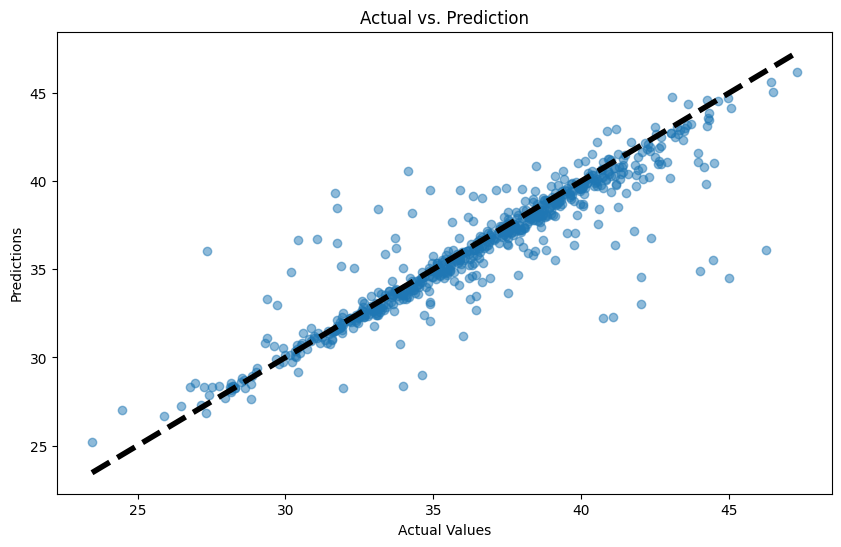

[0, 1]


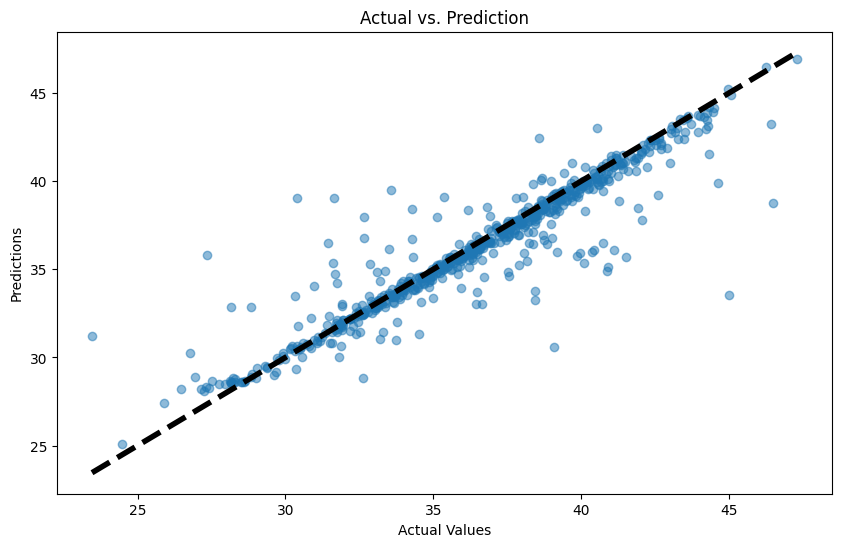

[0, 1, 2]


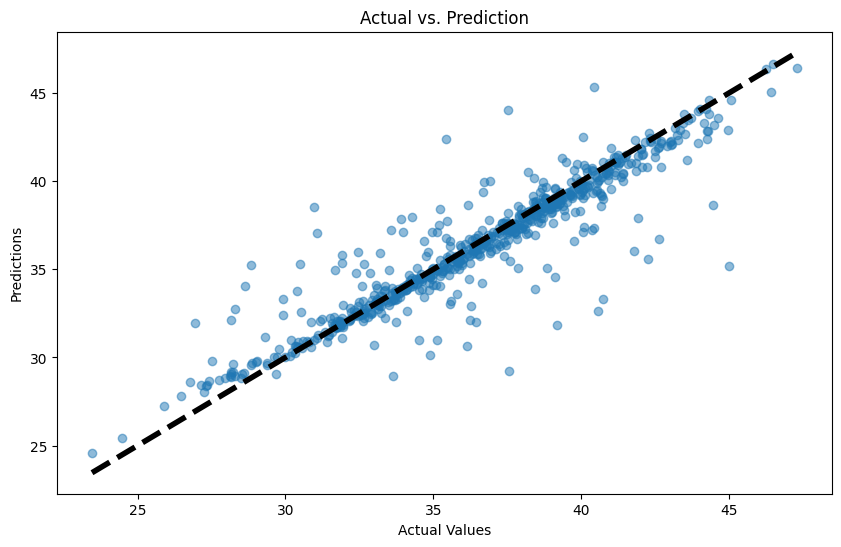

[0, 1, 2, 3]


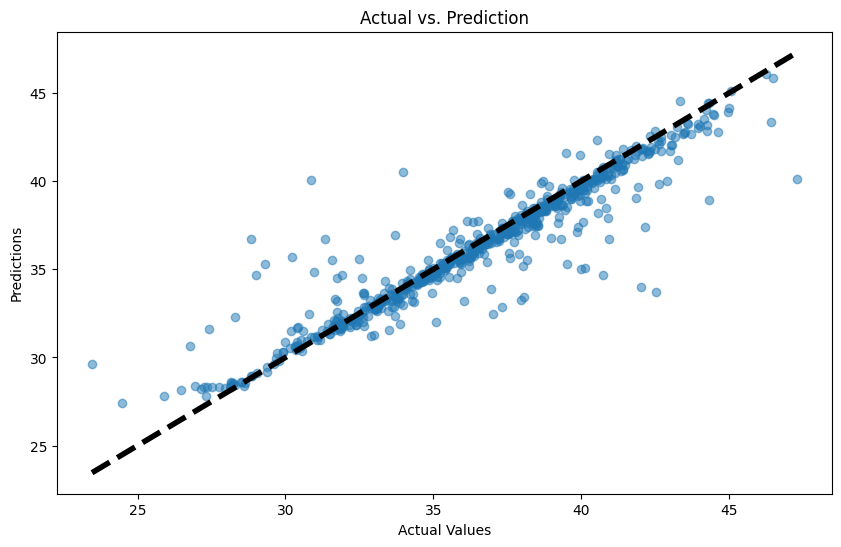

[0, 1, 2, 3, 4]


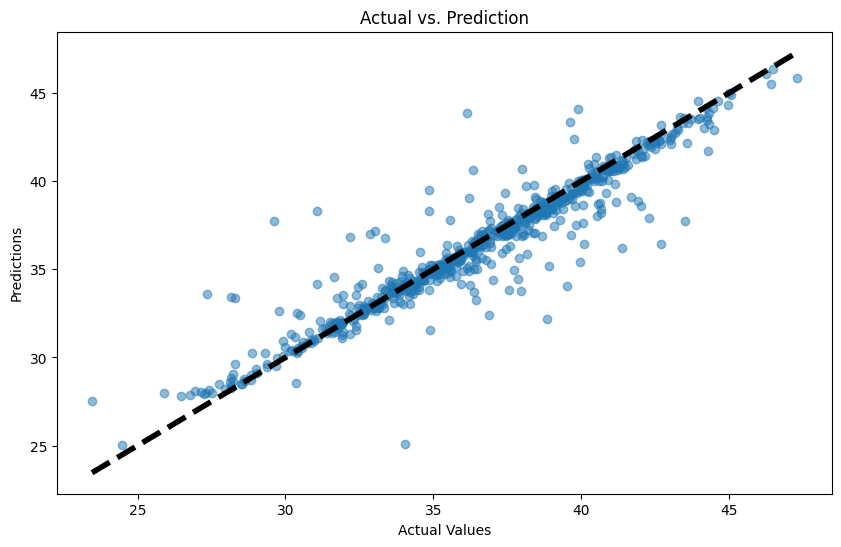

[0, 1, 2, 3, 4, 5]


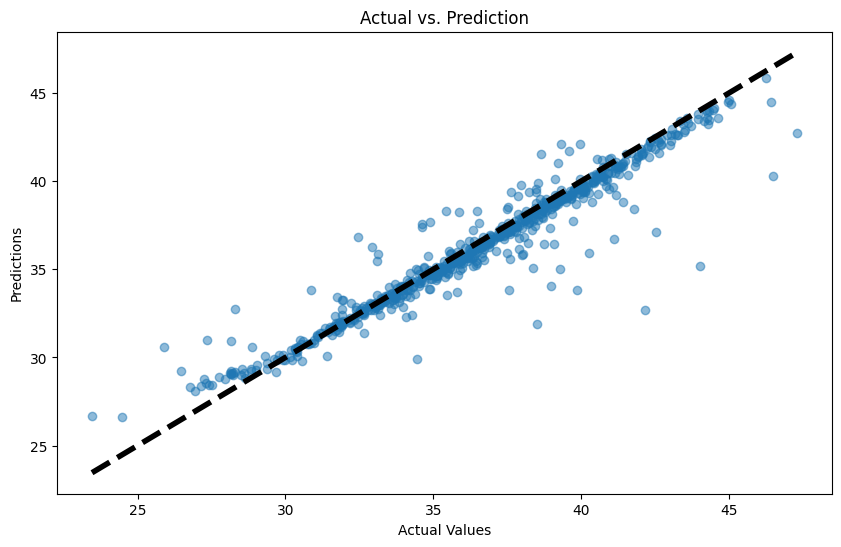

[0, 1, 2, 3, 4, 5, 6]


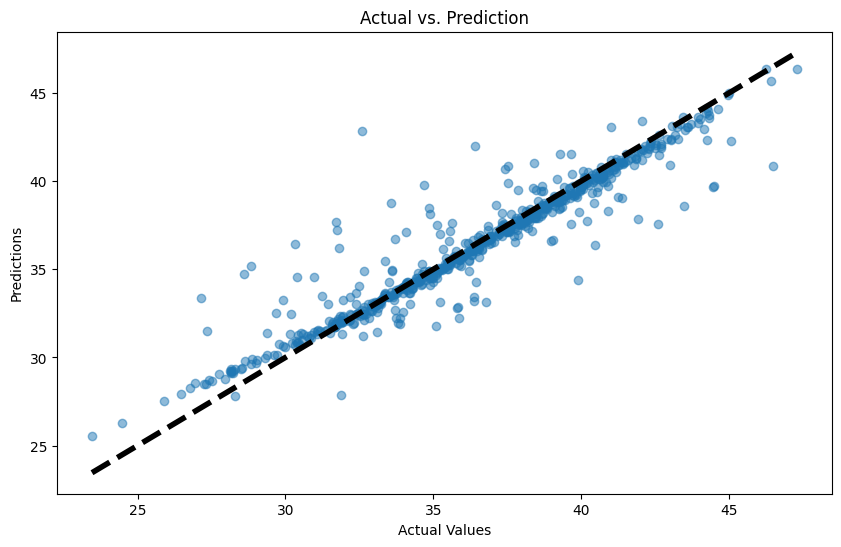

[0, 1, 2, 3, 4, 5, 6, 7]


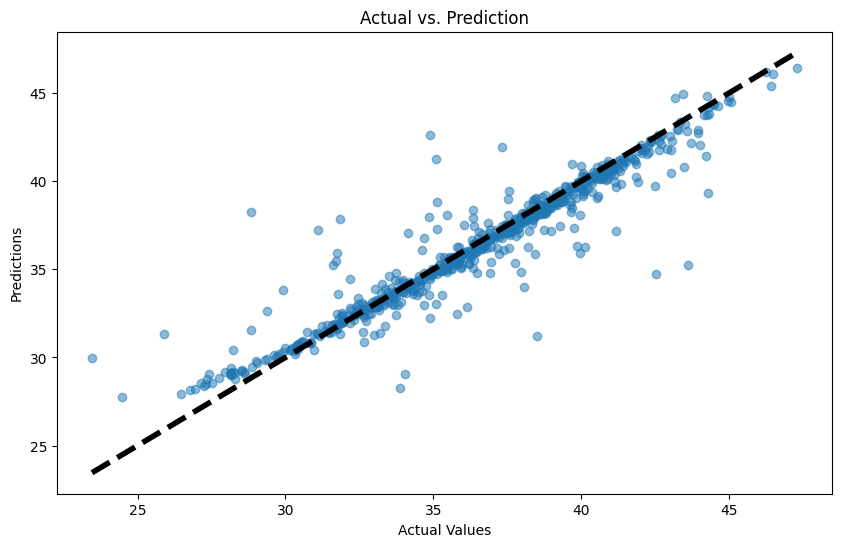

[0, 1, 2, 3, 4, 5, 6, 7, 8]


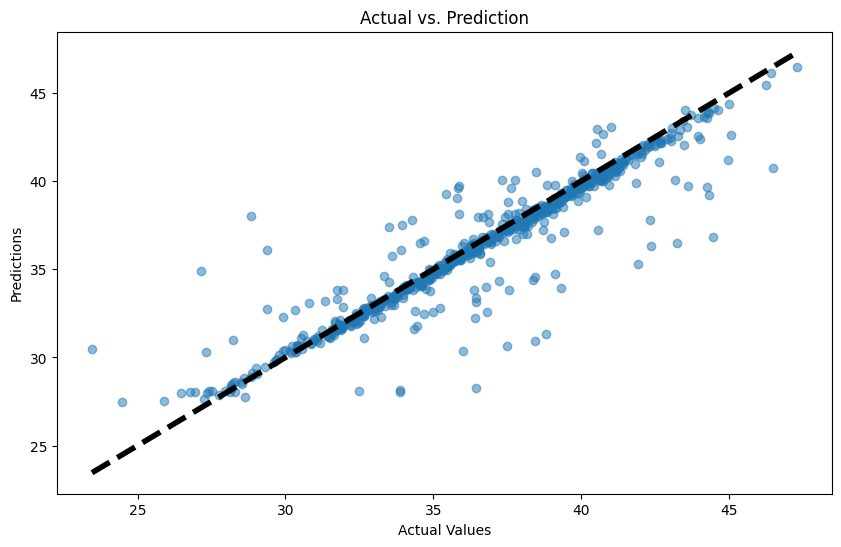

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


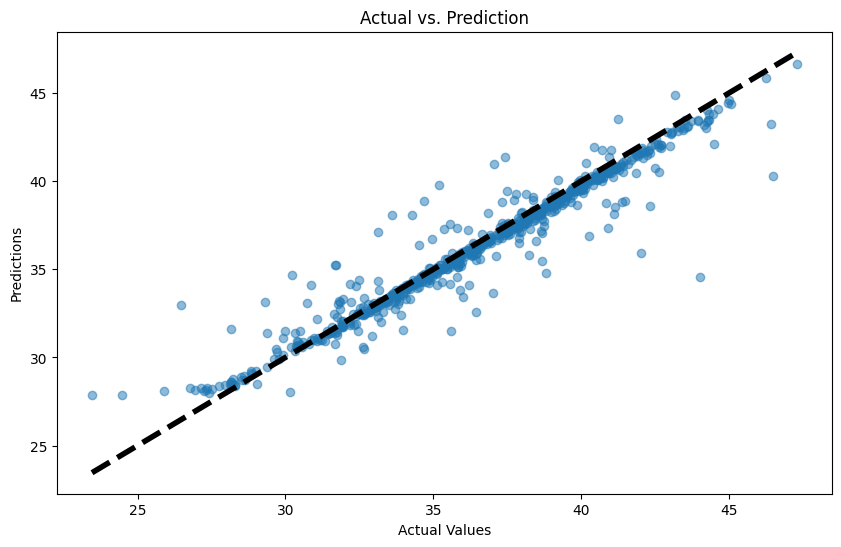

[0, 1, 3, 6, 7]


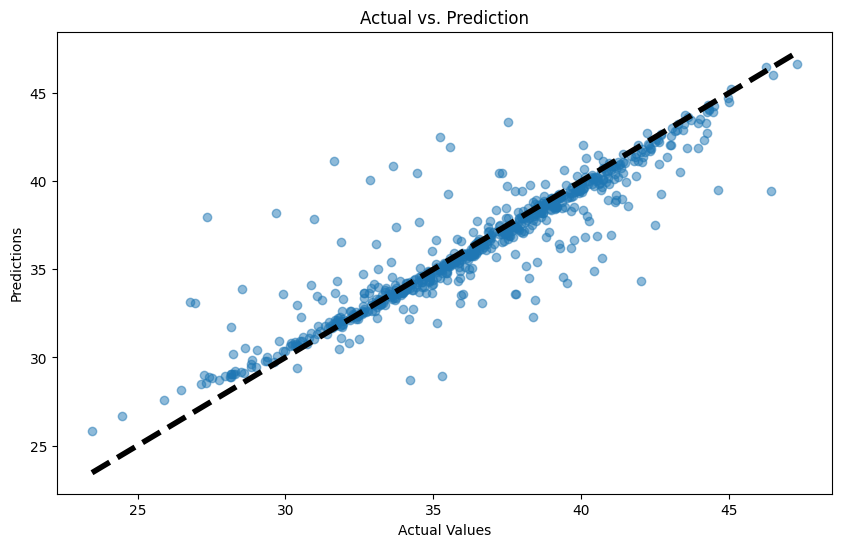

[5, 2, 4, 9, 8]


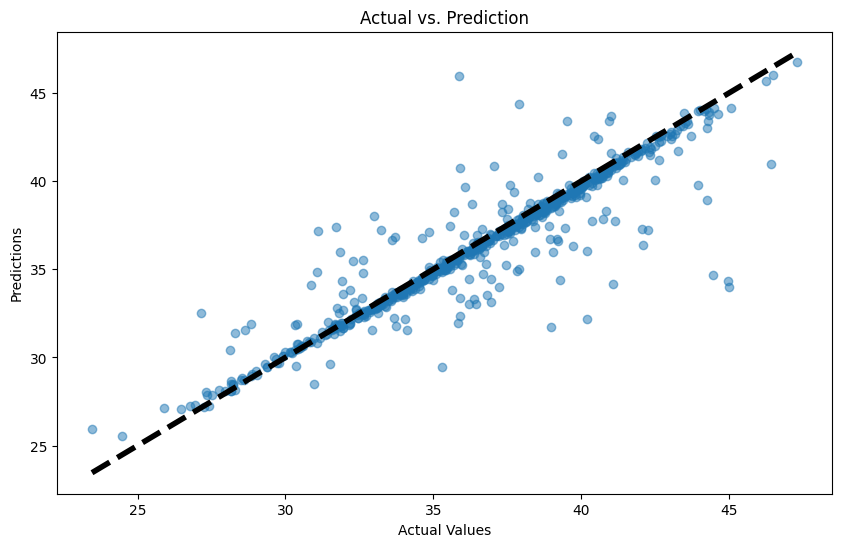

[0, 5]


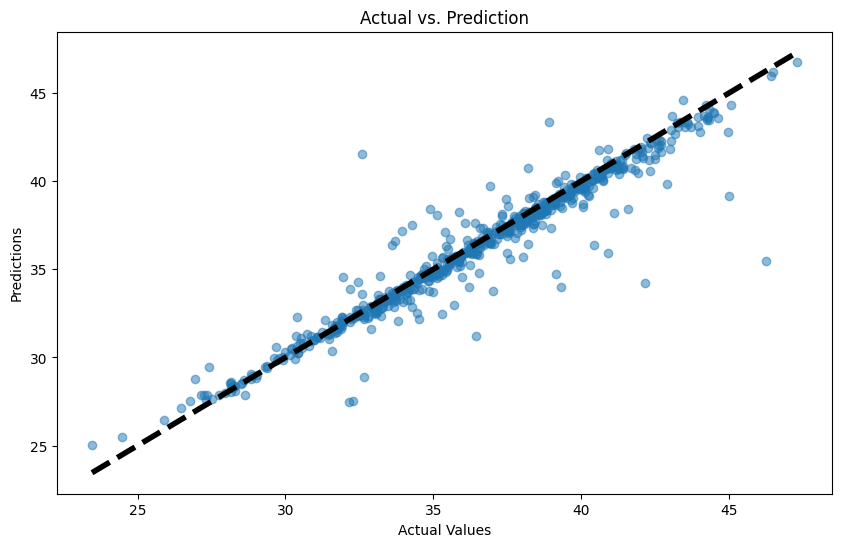

[1, 2]


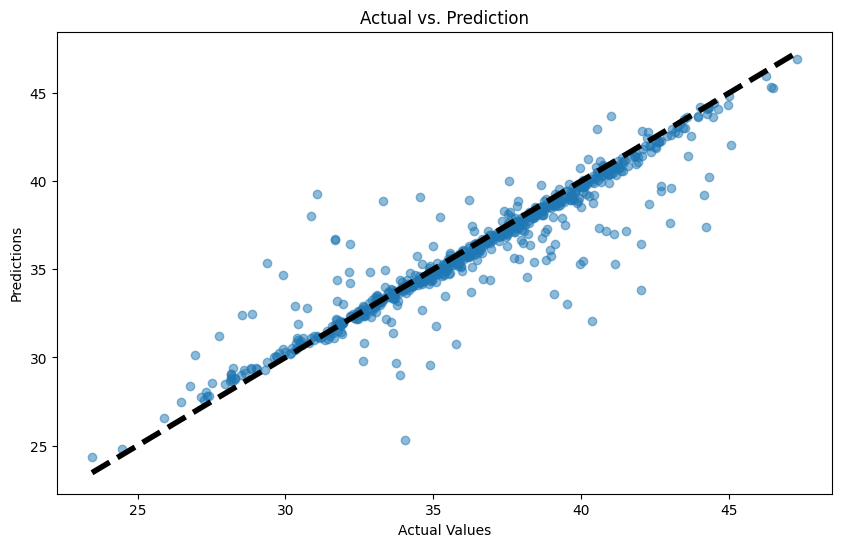

[3, 4]


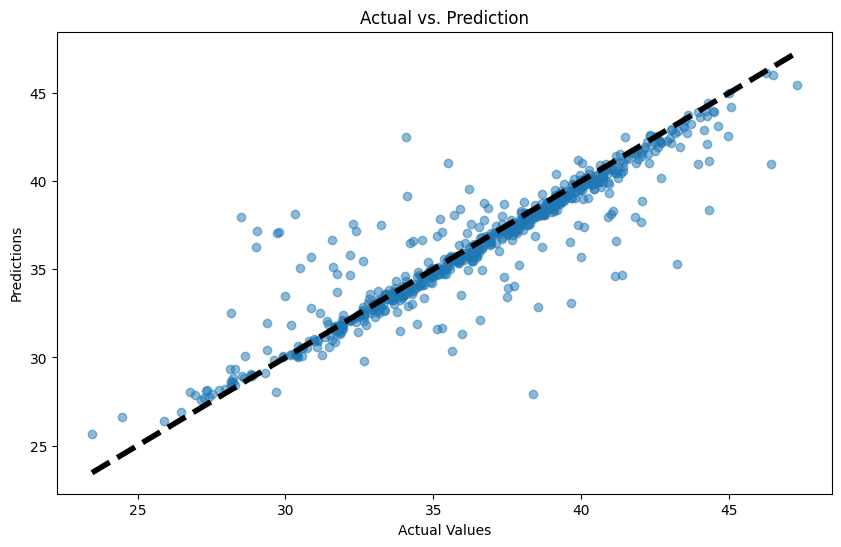

[6, 9]


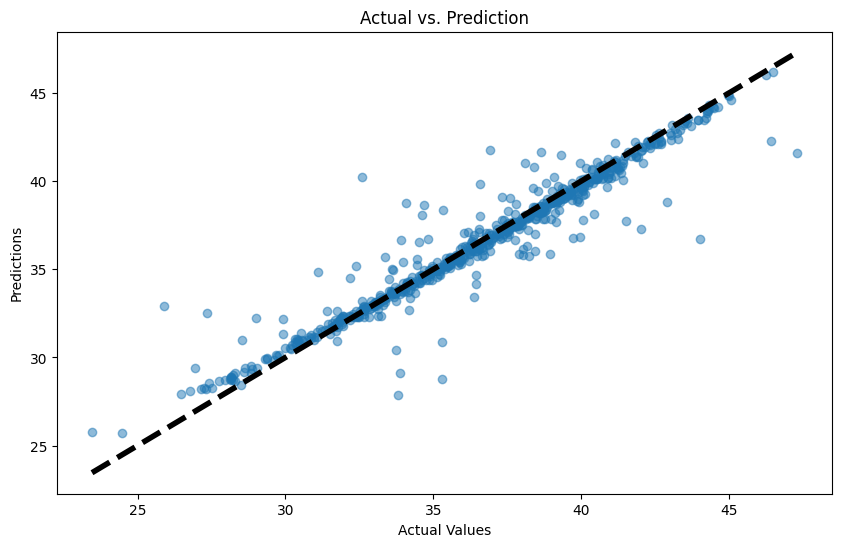

[7, 8]


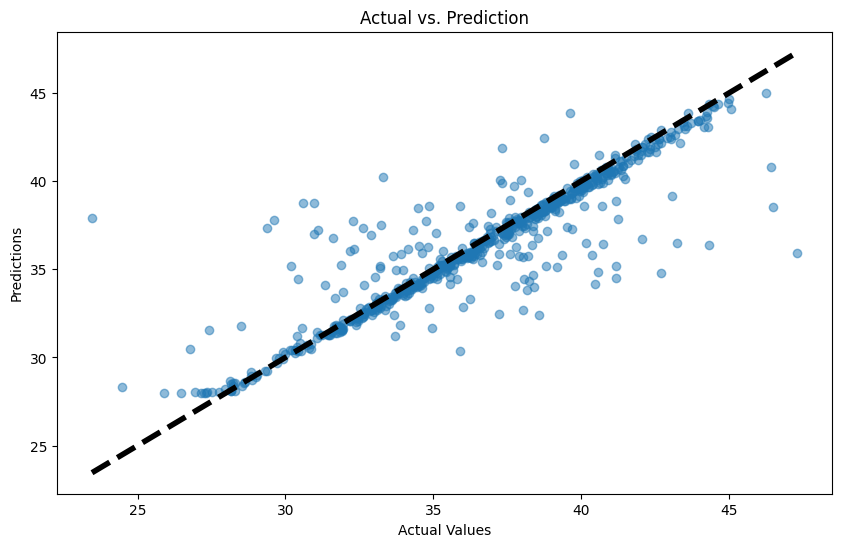

[0, 1, 3]


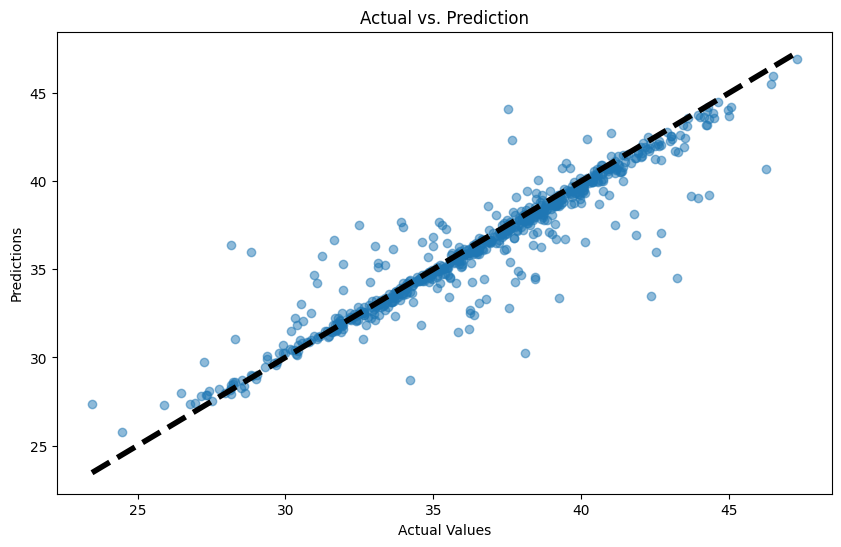

[5, 2, 5]


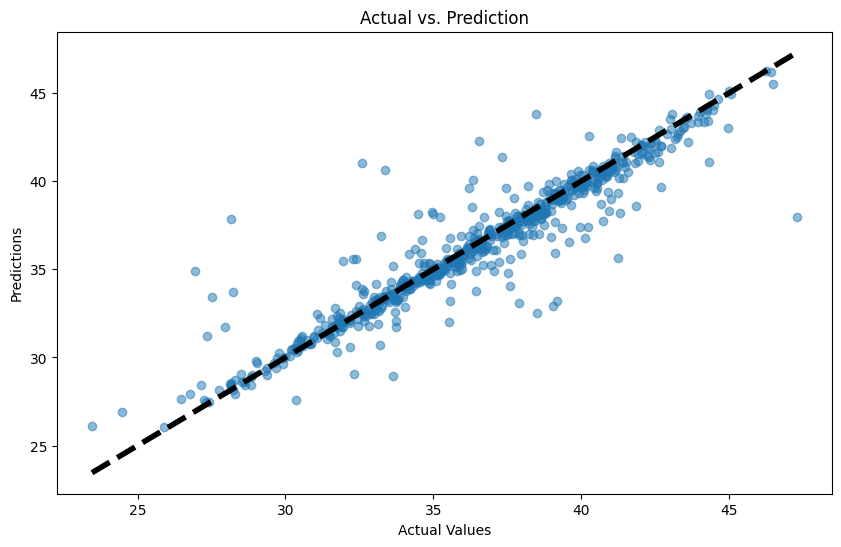

[6, 9, 7, 8]


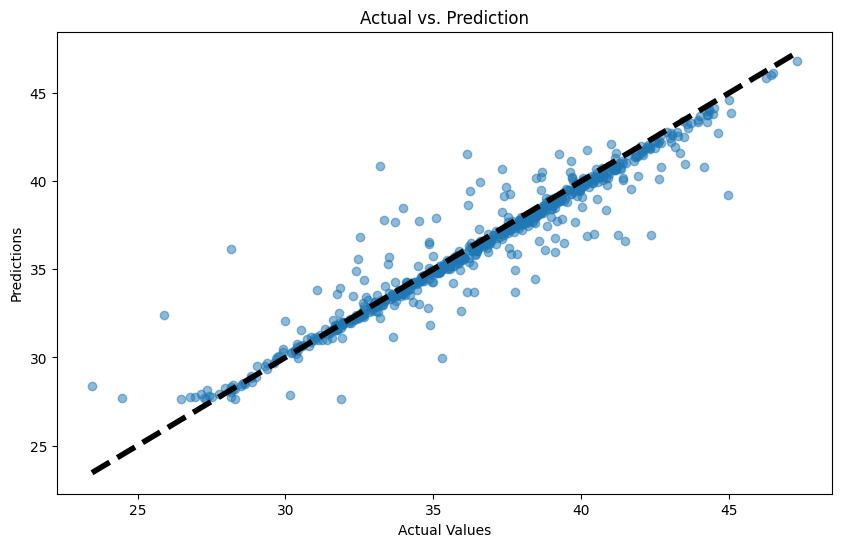

In [16]:
for i in range(len(model_performance)):
    atom_num = len(atom_list[i])
    dataset = get_datalist(data_list,atom_list[i])
    
    train_size = int(0.80 * len(dataset))
    test_size = len(dataset) - train_size
    
    torch.manual_seed(2025)
    # Randomly partition the data set
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    
    
    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

    print(atom_list[i])
    model_Performance(train_dataloader,model_performance[i][0])

In [ ]:
model_performance=[]
for i in range(len(atom_list)):
    tmp = train_and_test(atom_list[i],data_list)
    print(atom_list[i],min(tmp[2]))
    model_performance.append(tmp)

In [49]:
for i in model_performance:
    print(i[1][-1],min(i[2]))

1.9890624444659164 5.683997815563565
2.141946042819721 12.927384421938942
2.0252130605825562 6.423762610980442
1.9611193635841695 6.171825618970962
2.006388535950242 5.850223694528852
1.9928933345690005 4.944186840738569
2.0140795882155254 7.3141859372456866
2.125855705360087 4.691398194858006
1.8022368786538518 4.957515313511803
1.9980265996078166 8.986219434511094
1.9839044264176997 8.831187997545515
1.810670943158429 10.365340431531271
2.207057625782199 10.420304003215971


In [45]:
atom_list

[[0, 5],
 [2, 3],
 [0, 2, 3, 5],
 [0, 1, 4, 5],
 [0, 1, 2, 3, 4, 5],
 [6, 0, 1, 2, 3, 4, 5, 9],
 [0, 1, 2, 7, 8, 3, 4, 5],
 [6, 0, 1, 2, 7, 8, 3, 4, 5, 9],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [5, 3, 2, 1, 0, 4],
 [5, 2, 2, 1, 3, 4],
 [0, 1, 2],
 [5, 4, 3]]

In [54]:
tmp = train_and_test(atom_list[0],data_list)

 72%|███████▏  | 715/1000 [19:33<07:47,  1.64s/it, Training=2.1, Validation=6.3]


KeyboardInterrupt: 

In [48]:
model_performance[0]=tmp

In [51]:
model_performance[0]

[60.953745190690206,
 37.307701895876626,
 39.76200878910902,
 36.92021687437848,
 27.71137917332533,
 28.389638993798233,
 31.87944269180298,
 27.02537220280345,
 27.99299400608714,
 23.800967379314145,
 25.98506138964397,
 27.484162127099385,
 25.736082792282104,
 30.33364144767203,
 27.468455343711668,
 21.002553904928813,
 22.169131244101177,
 23.77372966743097,
 20.548592253429135,
 23.100112228858762,
 20.58784145262183,
 18.82772286926828,
 21.953767567146116,
 19.701242981887447,
 18.721079791464458,
 16.29442048945078,
 18.308145139275528,
 16.899483157367243,
 18.502791486135344,
 16.398659403731184,
 16.419031143188477,
 14.76173215668376,
 15.08234065044217,
 16.295792870405243,
 13.616856197031533,
 12.742822164442481,
 12.674774069611619,
 12.672715469104487,
 14.440993274130472,
 12.528101700108225,
 12.615685695555152,
 10.90903106549891,
 11.31786818475258,
 12.052385612231928,
 10.725703931436307,
 10.49326621323097,
 10.872718675834376,
 10.546234011650085,
 11.26327

In [52]:
for i, result in enumerate(model_performance):
    model = result[0]  # 取出模型
    torch.save(model.state_dict(), f'model_{i}_weights.pth')
    print(f"Model {i} 已保存为 model_{i}_weights.pth")


Model 0 已保存为 model_0_weights.pth
Model 1 已保存为 model_1_weights.pth
Model 2 已保存为 model_2_weights.pth
Model 3 已保存为 model_3_weights.pth
Model 4 已保存为 model_4_weights.pth
Model 5 已保存为 model_5_weights.pth
Model 6 已保存为 model_6_weights.pth
Model 7 已保存为 model_7_weights.pth
Model 8 已保存为 model_8_weights.pth
Model 9 已保存为 model_9_weights.pth
Model 10 已保存为 model_10_weights.pth
Model 11 已保存为 model_11_weights.pth
Model 12 已保存为 model_12_weights.pth


In [53]:
import pickle

# 保存整个model_performance列表到文件
with open('model_performance.pkl', 'wb') as f:
    pickle.dump(model_performance, f)

print("model_performance 列表已经保存到 model_performance.pkl")


model_performance 列表已经保存到 model_performance.pkl


In [ ]:
model.eval()
total_val_loss = 0.0
with torch.no_grad():
    for x3d, x2d, x1d, x0d, targets  in test_dataloader:
        x3d, x2d, x1d, targets = x3d.to(device), x2d.to(device), x1d.to(device), targets.to(device)
        outputs = model(x3d,x2d,x1d)
        loss = criterion(outputs, targets)
        total_val_loss += loss.item()

avg_val_loss = total_val_loss / len(test_dataloader)

In [59]:
for i, result in enumerate(model_performance):
    atom_num = len(atom_list[i])
    dataset = get_datalist(data_list,atom_list[i])
    
    train_size = int(0.80 * len(dataset))
    test_size = len(dataset) - train_size
    
    torch.manual_seed(2025)
    # Randomly partition the data set
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    
    
    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)
    model = result[0]  # 取出模型
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for x3d, x2d, x1d, x0d, targets  in test_dataloader:
            x3d, x2d, x1d, targets = x3d.to(device), x2d.to(device), x1d.to(device), targets.to(device)
            outputs = model(x3d,x2d,x1d)
            loss = criterion(outputs, targets)
            total_val_loss += loss.item()
    
    avg_val_loss = total_val_loss / len(test_dataloader)
    print(avg_val_loss)

6.419627904891968
14.140694027855282
7.355205899193173
7.175068350065322
6.624742581730797
5.333665819395156
8.853744075411843
5.100932461874826
5.575939467975071
9.54849150067284
10.80225287732624
11.721324841181437
12.189002465634118


In [56]:
    criterion = nn.MSELoss()
